In [ ]:
# Before we start let's connect local resources so we can run on our own GPU
!pip install jupyter_http_over_ws


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!jupyter serverextension enable —py jupyter_http_over_ws

Enabling: —py
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —py
      X is —py importable?
Enabling: jupyter_http_over_ws
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension jupyter_http_over_ws
      X is jupyter_http_over_ws importable?


# Transfer learning with TensorFlow part: Feature extraction

Transfer learning is leveraging working model's existing architecture and learned parameters for our own problems.
There are two main benefits:
1. Can leverage existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working network architecture which has already learn patterns on similar data to our own, then we can adapt those patterns to our own data

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-01-12 12:18:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.4s    

2022-01-12 12:18:31 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the data
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

## Creating data loaders

We'll use the ImageDataGenerator class to load our images in batches like before

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE
                                                          )
print('Testing images:')                                                        
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE
                                                        )


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelChechpoint callbakc
* Stopping a model from training (before it trains too long) early Stopping

In [ ]:
# Create tensorboard callback (functionalized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print('Saving log files to', log_dir)

  return tensorboard_callback


## Creating models using tensorflow hub

In the past we've used Tensorflow to create our own models from scratch.
Now we will do the same but import already trained models from tensorflow hub

We can find those on: https://tfhub.dev/ 

We browsed and found this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D 
from tensorflow.keras import Sequential
import tensorflow_hub as hub

In [ ]:
# Compare two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficient_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Lets create model function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Create a model from URL

  Args: 
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

  Return: 
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # First get the trained layer downloaded
  feature_extraction_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))
  
  # Create the model with the layer
  model = tf.keras.Sequential([
                               feature_extraction_layer,
                               tf.keras.layers.Dense(num_classes, activation='softmax', name='out_layer') # Can add activation as function parameter
  ])
  
  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create resnet model
resnet_model = create_model(resnet_url)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 out_layer (Dense)           (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])


In [ ]:
# Create callback
tensorboard_callback = create_tensorboard_callback('tensor_boards', 'resnet')

Saving log files to tensor_boards/resnet/20220112-124646


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[tensorboard_callback])

Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 2.0166 - accuracy: 0.3427 - val_loss: 1.2024 - val_accuracy: 0.6308
Epoch 2/5
24/24 [==============================] - 21s 915ms/step - loss: 0.9318 - accuracy: 0.7280 - val_loss: 0.8749 - val_accuracy: 0.7176
Epoch 3/5
24/24 [==============================] - 21s 912ms/step - loss: 0.6328 - accuracy: 0.8093 - val_loss: 0.7635 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 21s 912ms/step - loss: 0.4830 - accuracy: 0.8787 - val_loss: 0.7296 - val_accuracy: 0.7564
Epoch 5/5
24/24 [==============================] - 21s 901ms/step - loss: 0.3908 - accuracy: 0.9040 - val_loss: 0.6837 - val_accuracy: 0.7740


In [ ]:
resnet_model.evaluate(test_data_10_percent)

79/79 [==============================] - 17s 208ms/step - loss: 0.6680 - accuracy: 0.7708


[0.6680155992507935, 0.770799994468689]

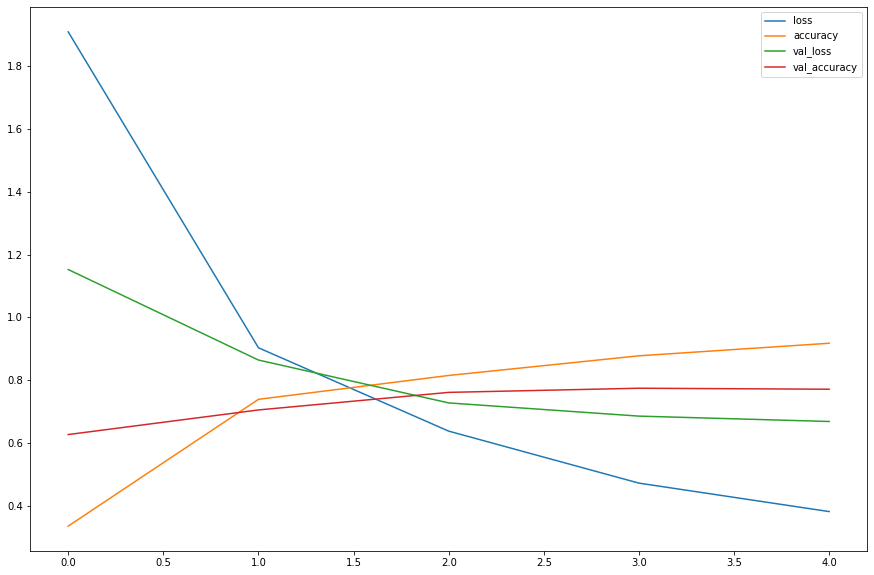

In [ ]:
import pandas as pd

pd.DataFrame(resnet_history.history).plot(figsize=(15, 10))

### Creating and testing EfficientNet Tensorflow Hub feature extraction model

In [ ]:
# Create model
efficient_model = create_model(efficient_url)

# Compile model
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

# Train the model
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=(len(train_data_10_percent)),
                                        validation_data=test_data_10_percent,
                                        validation_steps=len(test_data_10_percent),
                                        callbacks=[tensorboard_callback])

Epoch 1/5
24/24 [==============================] - 41s 881ms/step - loss: 1.8443 - accuracy: 0.4373 - val_loss: 1.3038 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 18s 783ms/step - loss: 1.0585 - accuracy: 0.7973 - val_loss: 0.8666 - val_accuracy: 0.8096
Epoch 3/5
24/24 [==============================] - 18s 783ms/step - loss: 0.7460 - accuracy: 0.8453 - val_loss: 0.7013 - val_accuracy: 0.8356
Epoch 4/5
24/24 [==============================] - 18s 783ms/step - loss: 0.5989 - accuracy: 0.8613 - val_loss: 0.6125 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 18s 778ms/step - loss: 0.5046 - accuracy: 0.8867 - val_loss: 0.5605 - val_accuracy: 0.8604


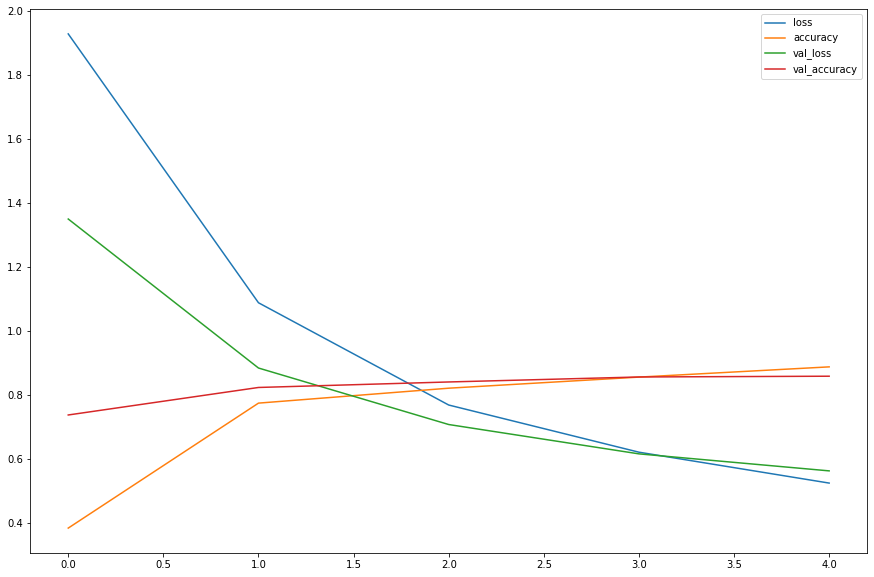

In [ ]:
# Plot curves
pd.DataFrame(efficient_history.history).plot(figsize=(15, 10))

In [ ]:
# How many layers does the efficientnet have?
len(efficient_model.layers[0].weights)

309

## Different types of tranfer learning

* 'As is' transfer learning - using an existing model with no changes what so over (e.g using ImageNet model on 1000 ImageNet classes)
* 'Feature extractioion'  transfer learning - use the prelearned patterns of an existing model (e.g Efficientnet trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> classes on food)
* 'Fine-tuning' transfer learning - use the prelearned patterns of an existing model and "fine-fune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

In [ ]:
# Create variables for the folders

efficient_tenboard = 'tensor_boards/efficientnet/20220112-121921'
resnet_tenboard = 'tensor_boards/resnet/20220112-124646'

In [ ]:
!tensorboard dev upload --logdir tensor_boards/efficientnet --name 'First comparisson experiment' --description 'Feature extraction from, efficientnet' --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/vlKsYFKKR8WL2bX5Jw2vJw/

[2022-01-12T12:58:16] Started scanning logdir.
[2022-01-12T12:58:19] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (3.9 MB)
[2022-01-12T12:58:19] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/vlKsYFKKR8WL2bX5Jw2vJw/


In [ ]:
# Upload tensorboard dev
!tensorboard dev upload --logdir tensor_boards/resnet --name 'First comparisson experiment 2' --description 'Feature extraction from resnet' --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/5vAv5NtqQQyFDimpdO8RMw/

[2022-01-12T13:00:10] Started scanning logdir.
[2022-01-12T13:00:12] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (1.6 MB)
[2022-01-12T13:00:12] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/5vAv5NtqQQyFDimpdO8RMw/


Our tensorboard experiments are uploaded publically here: https://tensorboard.dev/experiment/5vAv5NtqQQyFDimpdO8RMw/

I did an ooopsie. I could have taken both the architecture from the folder at the same  time.

In [ ]:
# Fack it lets take both of them
!tensorboard dev upload --logdir ./tensor_boards --name 'Comparing resnet vs efficientnet' \
                                                 --description 'Using 10% of food data and trying to classify on 10 classes using feature vector from resnet and efficientnet' \
                                                 --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/BkW68aQ9TXWIbGNKQQd4Yw/

[2022-01-12T13:07:22] Started scanning logdir.
[2022-01-12T13:07:26] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2022-01-12T13:07:26] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/BkW68aQ9TXWIbGNKQQd4Yw/


Here is the proper link with both of them in one: https://tensorboard.dev/experiment/BkW68aQ9TXWIbGNKQQd4Yw/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/BkW68aQ9TXWIbGNKQQd4Yw/
	Name                 Comparing resnet vs efficientnet
	Description          Using 10% of food data and trying to classify on 10 classes using feature vector from resnet and efficientnet
	Id                   BkW68aQ9TXWIbGNKQQd4Yw
	Created              2022-01-12 13:07:22 (1 minute ago)
	Updated              2022-01-12 13:07:26 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5797461
https://tensorboard.dev/experiment/5vAv5NtqQQyFDimpdO8RMw/
	Name                 First comparisson experiment 2
	Description          Feature extraction from resnet
	Id                   5vAv5NtqQQyFDimpdO8RMw
	Created              2022-01-12 13:00:10 (9 minutes ago)
	Updated              2022-01-12 13:00:12 (9 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1722421
https://tensorb

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id vlKsYFKKR8WL2bX5Jw2vJw

Deleted experiment vlKsYFKKR8WL2bX5Jw2vJw.


In [ ]:
!tensorboard dev delete --experiment_id 5vAv5NtqQQyFDimpdO8RMw

Deleted experiment 5vAv5NtqQQyFDimpdO8RMw.


In [ ]:
# Check if they are deleted
!tensorboard dev list

https://tensorboard.dev/experiment/BkW68aQ9TXWIbGNKQQd4Yw/
	Name                 Comparing resnet vs efficientnet
	Description          Using 10% of food data and trying to classify on 10 classes using feature vector from resnet and efficientnet
	Id                   BkW68aQ9TXWIbGNKQQd4Yw
	Created              2022-01-12 13:07:22 (3 minutes ago)
	Updated              2022-01-12 13:07:26 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5797461
Total: 1 experiment(s)


In [ ]:
# Extra tasks 
# Task 1 create new model on mobilenet_v2
mobilenet_v2 = create_model('https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4')

mobilenet_v2.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

mobilenet_history = mobilenet_v2.fit(train_data_10_percent,
                                     epochs=5,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data_10_percent,
                                     validation_steps=len(test_data_10_percent),
                                     callbacks=[create_tensorboard_callback('MobileNet_V2',
                                                                            'extra_tasks')])


Saving log files to MobileNet_V2/extra_tasks/20220112-132441
Epoch 1/5
24/24 [==============================] - 24s 814ms/step - loss: 1.9659 - accuracy: 0.3240 - val_loss: 1.3005 - val_accuracy: 0.6324
Epoch 2/5
24/24 [==============================] - 18s 761ms/step - loss: 1.0547 - accuracy: 0.6907 - val_loss: 0.8985 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 18s 767ms/step - loss: 0.7489 - accuracy: 0.7933 - val_loss: 0.7627 - val_accuracy: 0.7744
Epoch 4/5
24/24 [==============================] - 18s 785ms/step - loss: 0.5996 - accuracy: 0.8413 - val_loss: 0.6908 - val_accuracy: 0.7936
Epoch 5/5
24/24 [==============================] - 18s 779ms/step - loss: 0.4960 - accuracy: 0.8813 - val_loss: 0.6477 - val_accuracy: 0.7968


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('drive/')

Mounted at drive/


In [ ]:
# Taks 2; own learning network
train_dir = '/content/drive/MyDrive/oven_micro/train/'
test_dir = '/content/drive/MyDrive/oven_micro/test/'


In [ ]:
# Become one with the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def plot_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  imgplot = plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')

  return img

Image shape: (1816, 4032, 3)


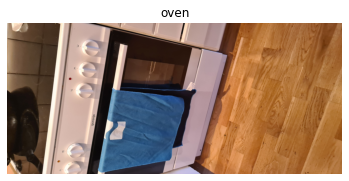

In [ ]:
img = plot_random_image(train_dir, 'oven')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               )
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224))

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
imagenet21k = create_model('https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5', num_classes=2)




In [ ]:
imagenet21k.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

imagenet21k_history = imagenet21k.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[create_tensorboard_callback('imagenet21k', 'my_own_experiment')])

Saving log files to imagenet21k/my_own_experiment/20220112-142445
Epoch 1/5
1/1 [==============================] - 17s 17s/step - loss: 0.5843 - accuracy: 0.6875 - val_loss: 0.5489 - val_accuracy: 0.7500
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.4378 - accuracy: 0.7500 - val_loss: 0.4709 - val_accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.3307 - accuracy: 0.8750 - val_loss: 0.4175 - val_accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.2504 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.7500
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.1890 - accuracy: 1.0000 - val_loss: 0.3325 - val_accuracy: 0.7500


In [ ]:
!tensorboard dev upload --logdir ./imagenet21k --name 'My own test' \
                                                 --description 'Took 10 pictures of a micro oven and an oven. Turns out that they were flipped and that kinda sucked. But it managed to get 75%. I used imagenet or something. ' \
                                                 --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/h3WGv6SkSNKgjF2BVF4rSw/

[2022-01-12T14:33:55] Started scanning logdir.
[2022-01-12T14:33:57] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (2.1 MB)
[2022-01-12T14:33:57] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/h3WGv6SkSNKgjF2BVF4rSw/


Here is the link for the network I created myself: https://tensorboard.dev/experiment/h3WGv6SkSNKgjF2BVF4rSw/

**Note:** I could have just used binary classification for this. Maybe I would have done better. But it was just two pictures. 

In [ ]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [ ]:
  # Extra tasks
  mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
  inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [ ]:
classifier_model = mobilenet_v2

IMAGE_SHAPE = (224, 224)

In [ ]:
classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])


In [ ]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

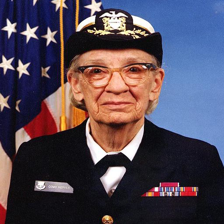

In [ ]:
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper) /255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
# Add a batch dimension (with np.newaxis) and pass the image to the model:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
# The returned array is a vector of logits, rating the probability of each class for the image
predicted_class = tf.math.argmax(result[0])
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [ ]:
# What is 653? Fetch the label data
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


In [ ]:
imagenet_labels.shape

(1001,)

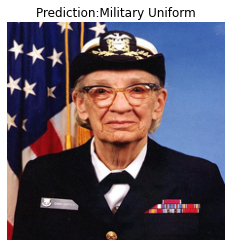

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction:' + predicted_class_name.title())

In [ ]:
# New example toy set
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)


228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, label_batch, in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [ ]:
result_batch = classifier.predict(train_ds)

In [ ]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

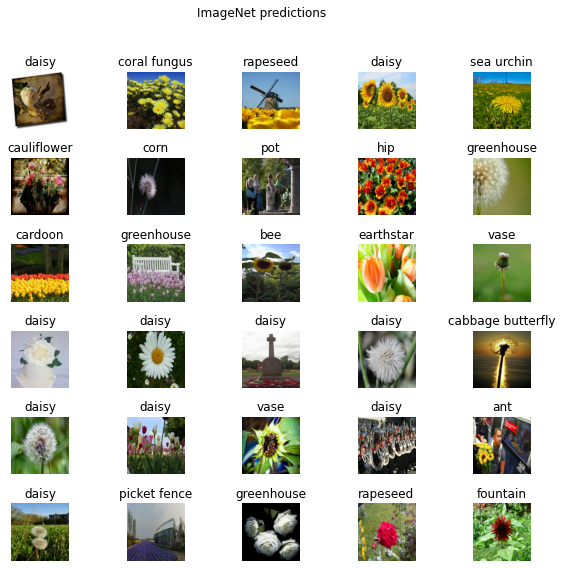

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

**Note:** There is a difference between classification from hub and feature vector. The feature vector is there for you to continue training on your own data set so that you can do your own classification. 

In [ ]:
mobilenet_v2 = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
inception_v3 = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'

feature_extractor_model = mobilenet_v2

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, 
    input_shape=(224, 224, 3),
    trainable=False
)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
num_classes = len(class_names)
num_classes

5

In [ ]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

Notice that to create a tensorboard callback you name the directory you want it in and then you use the tf.keras.callbacks.TensorBoard(). Use whatever additional thing you want as well accordning to: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
# Create tensorboard callback
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

In [ ]:
# train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=tensorboard_callback)

Epoch 1/10
92/92 [==============================] - 17s 141ms/step - loss: 0.7465 - acc: 0.7282 - val_loss: 0.4544 - val_acc: 0.8556
Epoch 2/10
92/92 [==============================] - 11s 117ms/step - loss: 0.3722 - acc: 0.8777 - val_loss: 0.3641 - val_acc: 0.8869
Epoch 3/10
92/92 [==============================] - 11s 119ms/step - loss: 0.2923 - acc: 0.9080 - val_loss: 0.3312 - val_acc: 0.8937
Epoch 4/10
92/92 [==============================] - 11s 118ms/step - loss: 0.2440 - acc: 0.9261 - val_loss: 0.3148 - val_acc: 0.8883
Epoch 5/10
92/92 [==============================] - 11s 119ms/step - loss: 0.2095 - acc: 0.9401 - val_loss: 0.3054 - val_acc: 0.8951
Epoch 6/10
92/92 [==============================] - 11s 118ms/step - loss: 0.1830 - acc: 0.9510 - val_loss: 0.2993 - val_acc: 0.8978
Epoch 7/10
92/92 [==============================] - 11s 119ms/step - loss: 0.1617 - acc: 0.9567 - val_loss: 0.2950 - val_acc: 0.8992
Epoch 8/10
92/92 [==============================] - 11s 119ms/step - 

In [ ]:
# Check prediction 
m_prediction = model.predict(val_ds)

In [ ]:
pred_class_names = imagenet_labels[tf.math.argmax(m_prediction, axis=-1)]

In [ ]:
pred_class_names

array(['background', 'tiger shark', 'great white shark', 'background',
       'great white shark', 'tiger shark', 'tench', 'goldfish',
       'tiger shark', 'background', 'background', 'background',
       'background', 'tiger shark', 'tiger shark', 'great white shark',
       'great white shark', 'background', 'background',
       'great white shark', 'tench', 'tiger shark', 'tiger shark',
       'goldfish', 'background', 'great white shark', 'tench', 'goldfish',
       'tench', 'goldfish', 'goldfish', 'tench', 'tench', 'background',
       'tench', 'goldfish', 'background', 'tench', 'tench', 'tiger shark',
       'great white shark', 'great white shark', 'tiger shark',
       'tiger shark', 'great white shark', 'tiger shark', 'tiger shark',
       'great white shark', 'tiger shark', 'tench', 'tiger shark',
       'tench', 'tiger shark', 'tench', 'tench', 'tench', 'tiger shark',
       'goldfish', 'background', 'tiger shark', 'tiger shark', 'tench',
       'tench', 'tench', 'great whi

In [ ]:
# What the google thingy did
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


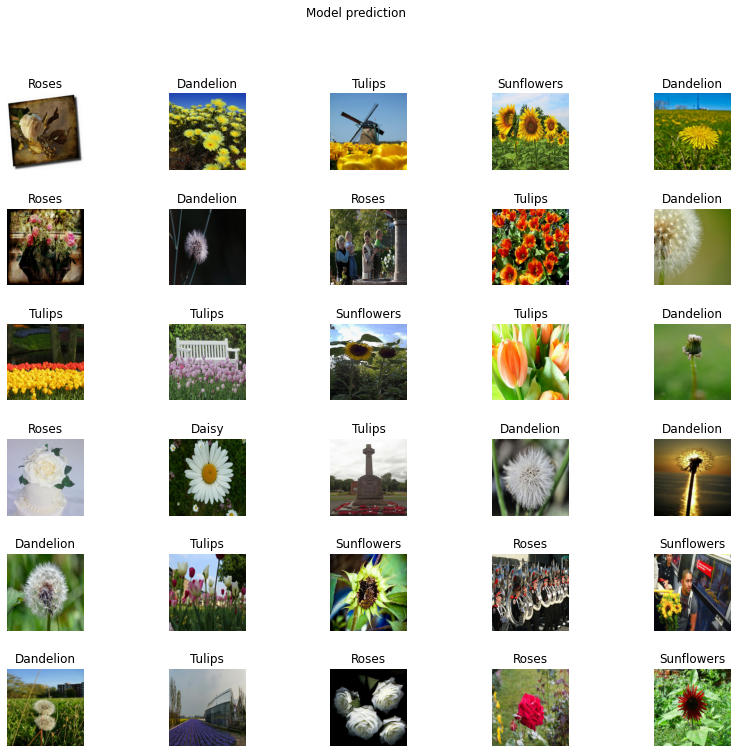

In [ ]:
plt.figure(figsize=(14, 12))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.axis('off')
  plt.title(predicted_label_batch[n].title())
_ = plt.suptitle('Model prediction')

In [ ]:
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1642065827/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1642065827/assets


'/tmp/saved_models/1642065827'

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_class = class_names[reloaded_predicted_id]
reloaded_predicted_class

array(['roses', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'roses',
       'dandelion', 'roses', 'tulips', 'dandelion', 'tulips', 'tulips',
       'sunflowers', 'tulips', 'dandelion', 'roses', 'daisy', 'tulips',
       'dandelion', 'dandelion', 'dandelion', 'tulips', 'sunflowers',
       'roses', 'sunflowers', 'dandelion', 'tulips', 'roses', 'roses',
       'sunflowers', 'tulips', 'sunflowers'], dtype='<U10')

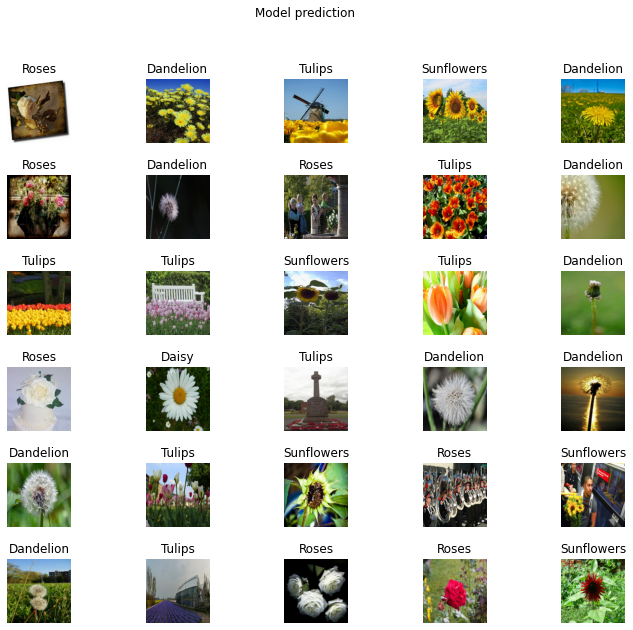

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
  plt.subplot(6, 5, i+1)
  plt.imshow(image_batch[i])
  plt.axis('off')
  plt.title(reloaded_predicted_class[i].title()) # The only thing this shit title() does is to make the name of the class hav3e big first letter.
_ = plt.suptitle('Model prediction')